In [1]:
# Imports.
import random
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

Use a pre-trained network. It has been saved as a pickle file. Load the model, and continue.
The network has only one hidden layer of 30 units, 784 input units (MNIST images are $ 28 \times 28 = 784 $ pixels large), and 10 output units. All the activations are sigmoidal.

In [2]:
# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

# Helpful function to load the MNIST data.
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

BINARY_THRESHOLD = 0.5

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


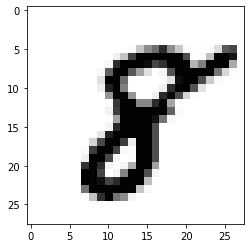

In [3]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]
    
    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

Helper functions to evaluate the non-linearity and it's derivative:

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to find the gradient derivatives of the cost function, $ \nabla_x C $ with respect to the input $ \vec x $, with a goal label of $ \vec y_{goal} $. (Don't worry too much about the implementation, just know it calculates derivatives).

In [5]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples and a wrapper function:

## (a) Non Targeted Attack

In [6]:
def nonTargetedAdversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    
    ####### Enter your code below #######
    
    # Initialize the goal output
    goal = np.zeros((10,1))
    # Set the goal output
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.rand(784,1)
    
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        derivate_x = input_derivative(net, x, goal)
    
        # The GD update on x
        x -= (eta*derivate_x)
            
    return x


# Wrapper function 
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    
    ####### Enter your code below #######
    
    # Find the vector x with the above function that you just wrote.
    a = nonTargetedAdversarial(net, n, 1000, 0.001)
    
    # Pass the generated image (vector) to the neural network. Perform a forward pass, and get the prediction.
    x = np.round(net.feedforward(a), 3)
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[0.   ]
 [0.   ]
 [0.973]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]]

Network Prediction: 2

Adversarial Example: 


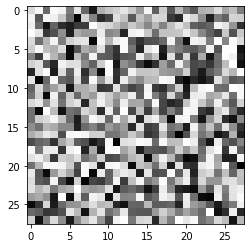

In [7]:
generate(2)

## (b) Targeted Attack(s)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [8]:
# Probably include a question on why not generate an image of 5, instead of having to find the vector x using 
# gradient based optimization methods. (as in the above case)

In [9]:
def targetedAdversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    # Initialize the goal output
    goal = np.zeros((10,1))
    goal[n] = 1
    
    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))
    
    # Gradient descent on the input
    for i in range(steps):
        
        # Calculate the derivative
        derivate_x = input_derivative(net, x, goal)
        
        # The GD update on x, with an added penalty to the cost function
        x -= eta*(derivate_x + lam*(x - x_target))
        
    return x

# Wrapper function
def generate_advSample(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = targetedAdversarial(net, n, test_data[idx][0], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


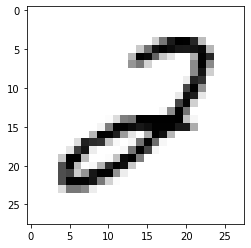



Adversarial Example: 


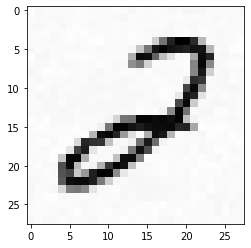

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.98]
 [0.  ]]



In [10]:
# generate_advSample(target label, target digit)
adv_ex = generate_advSample(8, 2)

## (c) Protection against adversarial attacks

Awesome! We’ve just created images that trick neural networks. The next question we could ask is whether or not we could protect against these kinds of attacks. If you look closely at the original images and the adversarial examples you’ll see that the adversarial examples have some sort of grey tinged background.

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [11]:
def simple_defense(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Generate an adversarial sample.
    x = generate_advSample(n, m)
    
    # Perform binary thresholding on the generated sample. You can choose the threshold as 0.5.
    # BINARY_THRESHOLD is a global varibale with value 0.5.
    for i in range(len(x)):
        x[i][0] = 0 if x[i][0] < BINARY_THRESHOLD else 1
      
    print("With binary thresholding: ")
    
    # Plot a grayscale image of the binarized generated sample.
    plt.imshow(x.reshape(28,28), cmap='Greys')

    # Print the network's predictions.
    x = np.round(net.feedforward(x), 3)
    print("Prediction with binary thresholding: " + str(np.argmax(x)) + '\n')
    
    # The output of the network.
    print("Network output: ")
    print( str(x) )


What we want our adversarial example to look like: 


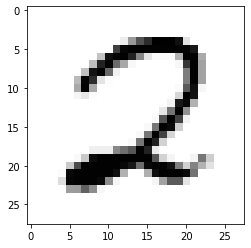



Adversarial Example: 


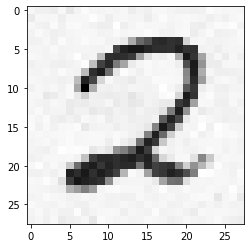

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [1.  ]
 [0.  ]]

With binary thresholding: 
Prediction with binary thresholding: 2

Network output: 
[[0.   ]
 [0.   ]
 [1.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.009]
 [0.   ]
 [0.   ]
 [0.   ]]


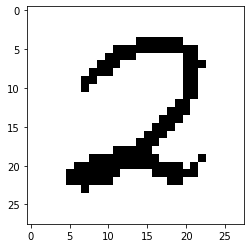

In [12]:
# binary_thresholding(target digit, actual digit)
simple_defense(8, 2)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.